In [11]:
from dictionary_learning.dictionary import BatchTopKCrossCoder
from tiny_dashboard.dashboard_implementations import CrosscoderOnlineFeatureDashboard
from nnsight import LanguageModel
import torch as th

In [12]:
# hugging face login removed for git push

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [14]:
crosscoder = BatchTopKCrossCoder.from_pretrained("science-of-finetuning/gemma-2-2b-L13-k100-lr1e-04-local-shuffling-CCLoss", from_hub=True, device="cuda")
gemma_2 = LanguageModel("google/gemma-2-2b", device_map="cuda")
gemma_2_it = LanguageModel("google/gemma-2-2b-it", device_map="cuda")


In [15]:
# Load the jokes dataset
jokes_df = pd.read_csv('shortjokes_500.csv')

# Initialize storage for non-zero feature indices
non_zero_indices = []

# Process each joke
for idx, row in tqdm(jokes_df.iterrows(), total=len(jokes_df), desc="Processing jokes"):
    joke = row['Joke']  # Get the joke from the 'Joke' column
    joke_tokens = gemma_2_it.tokenizer.encode(joke, add_special_tokens=True, return_tensors="pt")
    
    # Get activations from gemma-2-2b
    with gemma_2.trace(joke_tokens):
        l13_act_base = gemma_2.model.layers[13].output[0][:, -1].save()  # (1, 2304)
        gemma_2.model.layers[13].output.stop()
    
    # Get activations from gemma-2-2b-it
    with gemma_2_it.trace(joke_tokens):
        l13_act_it = gemma_2_it.model.layers[13].output[0][:, -1].save()  # (1, 2304)
        gemma_2_it.model.layers[13].output.stop()
    
    # Prepare input for crosscoder
    crosscoder_input = th.cat([l13_act_base, l13_act_it], dim=0).unsqueeze(0)  # (batch, 2, 2304)
    
    # Get reconstruction and features
    _, features = crosscoder(crosscoder_input, output_features=True)
    
    # Find indices of non-zero elements (> 1e-4)
    nonzero_mask = features.abs() > 1e-4
    nonzero_idx = nonzero_mask.nonzero().cpu().numpy()
    
    # Store the indices
    non_zero_indices.append([int(ni[1]) for ni in nonzero_idx])
    
    # Optional: Print progress info every 50 jokes
    if idx % 50 == 0 and idx > 0:
        print(f"Processed {idx} jokes. Latest non-zero count: {nonzero_mask.sum().item()}")


Processing jokes:   0%|          | 0/500 [00:00<?, ?it/s]You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Processing jokes:  10%|█         | 51/500 [00:08<00:38, 11.56it/s]

Processed 50 jokes. Latest non-zero count: 145


Processing jokes:  21%|██        | 103/500 [00:13<00:31, 12.57it/s]

Processed 100 jokes. Latest non-zero count: 177


Processing jokes:  31%|███       | 153/500 [00:17<00:26, 13.32it/s]

Processed 150 jokes. Latest non-zero count: 125


Processing jokes:  41%|████      | 203/500 [00:21<00:30,  9.81it/s]

Processed 200 jokes. Latest non-zero count: 125


Processing jokes:  51%|█████     | 253/500 [00:25<00:18, 13.49it/s]

Processed 250 jokes. Latest non-zero count: 121


Processing jokes:  61%|██████    | 303/500 [00:29<00:14, 13.18it/s]

Processed 300 jokes. Latest non-zero count: 146


Processing jokes:  71%|███████   | 353/500 [00:33<00:10, 13.39it/s]

Processed 350 jokes. Latest non-zero count: 128


Processing jokes:  81%|████████  | 403/500 [00:37<00:07, 13.31it/s]

Processed 400 jokes. Latest non-zero count: 117


Processing jokes:  91%|█████████ | 453/500 [00:41<00:03, 13.27it/s]

Processed 450 jokes. Latest non-zero count: 153


Processing jokes: 100%|██████████| 500/500 [00:44<00:00, 11.21it/s]


Saved non_zero_indices for 500 jokes to saved_data/non_zero_indices.pkl
Average non-zero elements per joke: 132.06
Min non-zero elements: 78
Max non-zero elements: 200
Number of unique feature indices activated across all jokes: 9207
Percentage of total features used: 12.49%


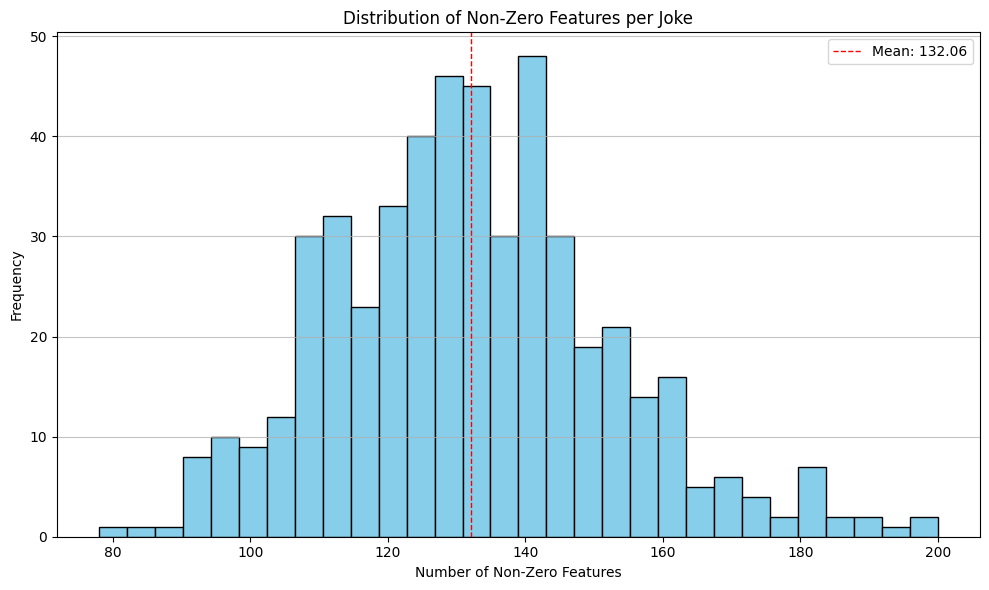

In [16]:
# Save non_zero_indices to a file for later use
import pickle
import os

# Create a directory for saved data if it doesn't exist
os.makedirs('saved_data', exist_ok=True)

# Save the non_zero_indices list using pickle
with open('non_zero_indices.pkl', 'wb') as f:
    pickle.dump(non_zero_indices, f)

print(f"Saved non_zero_indices for {len(non_zero_indices)} jokes to saved_data/non_zero_indices.pkl")

# Example of how to reload the data:
# with open('saved_data/non_zero_indices.pkl', 'rb') as f:
#     loaded_non_zero_indices = pickle.load(f)



# Summary statistics
total_nonzero_counts = [len(indices) for indices in non_zero_indices]
print(f"Average non-zero elements per joke: {np.mean(total_nonzero_counts):.2f}")
print(f"Min non-zero elements: {np.min(total_nonzero_counts)}")
print(f"Max non-zero elements: {np.max(total_nonzero_counts)}")
# Flatten all non-zero indices and count unique ones
all_indices = []
for indices in non_zero_indices:
    all_indices.extend(indices)
unique_indices = np.unique(all_indices)
print(f"Number of unique feature indices activated across all jokes: {len(unique_indices)}")
print(f"Percentage of total features used: {len(unique_indices) / features.shape[1] * 100:.2f}%")



# Create a histogram of non-zero feature counts
plt.figure(figsize=(10, 6))
plt.hist(total_nonzero_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Non-Zero Features per Joke')
plt.xlabel('Number of Non-Zero Features')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Add mean line
mean_count = np.mean(total_nonzero_counts)
plt.axvline(mean_count, color='red', linestyle='dashed', linewidth=1, 
            label=f'Mean: {mean_count:.2f}')

plt.legend()
plt.tight_layout()
plt.show()




Number of features appearing in more than 5 jokes: 2269
Percentage of features appearing in more than 5 jokes: 24.64%


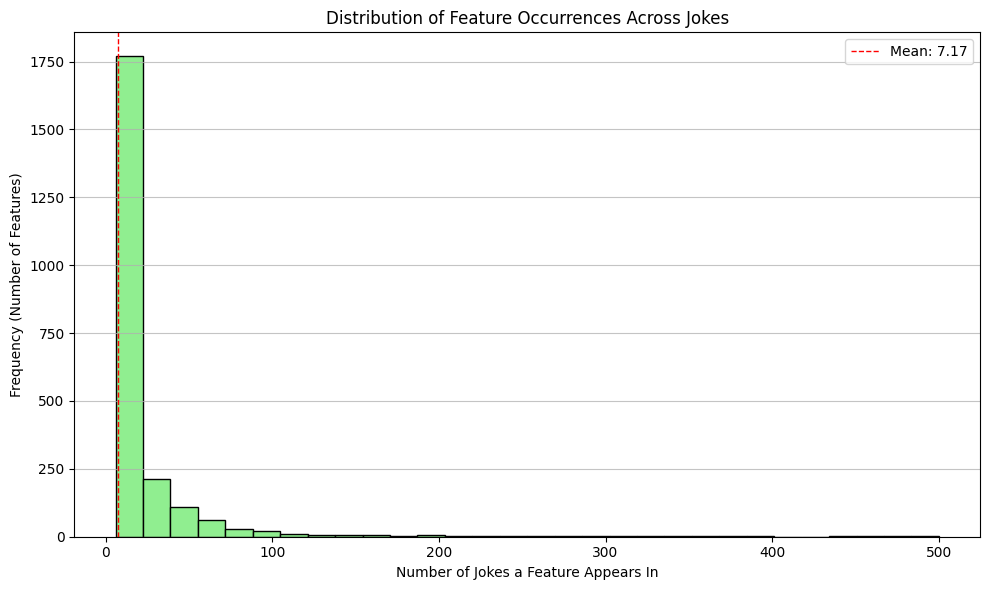

Total unique features found: 9207
Average number of jokes per feature: 7.17
Max number of jokes a feature appears in: 500


In [19]:
# Count how many jokes each feature appears in
feature_counts = {}
for joke_indices in non_zero_indices:
    for idx_val in joke_indices:
        if idx_val in feature_counts:
            feature_counts[idx_val] += 1
        else:
            feature_counts[idx_val] = 1

# Extract the counts for plotting
feature_occurrences = list(feature_counts.values())
# Filter features that appear in more than 5 jokes
filtered_feature_occurrences = [count for count in feature_occurrences if count > 5]
print(f"Number of features appearing in more than 5 jokes: {len(filtered_feature_occurrences)}")
print(f"Percentage of features appearing in more than 5 jokes: {len(filtered_feature_occurrences) / len(feature_occurrences) * 100:.2f}%")

# Create a histogram of feature occurrences
plt.figure(figsize=(10, 6))
plt.hist(filtered_feature_occurrences, bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Feature Occurrences Across Jokes')
plt.xlabel('Number of Jokes a Feature Appears In')
plt.ylabel('Frequency (Number of Features)')
plt.grid(axis='y', alpha=0.75)

# Add mean line
mean_occurrence = np.mean(feature_occurrences)
plt.axvline(mean_occurrence, color='red', linestyle='dashed', linewidth=1, 
            label=f'Mean: {mean_occurrence:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Total unique features found: {len(feature_counts)}")
print(f"Average number of jokes per feature: {mean_occurrence:.2f}")
print(f"Max number of jokes a feature appears in: {max(feature_occurrences)}")


In [20]:
# Find the features that appear in the most jokes
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 most common features in a table format
print("Top 10 features that appear in the most jokes:")
print("-" * 50)
print(f"{'Rank':<6}{'Feature ID':<12}{'Occurrence Count':<20}")
print("-" * 50)
for i, (feature_idx, count) in enumerate(sorted_features[:10]):
    print(f"{i+1:<6}{feature_idx:<12}{count:<20}")
print("-" * 50)

# Create a dictionary of the top features for easier reference
top_features = dict(sorted_features[:10])


Top 10 features that appear in the most jokes:
--------------------------------------------------
Rank  Feature ID  Occurrence Count    
--------------------------------------------------
1     69252       500                 
2     56694       489                 
3     43830       472                 
4     67792       457                 
5     71786       450                 
6     13469       439                 
7     23353       401                 
8     69922       399                 
9     23624       384                 
10    23547       360                 
--------------------------------------------------


In [21]:
from util import offline_dashboard
crosscoder_name = "gemma-2-2b-L13-k100-lr1e-04-local-shuffling-CCLoss"
offline_dashboard(crosscoder_name, max_example_per_quantile=10)

In [22]:
from tiny_dashboard.dashboard_implementations import CrosscoderOnlineFeatureDashboard

# Print the first joke from jokes_df
print("First joke in the dataset:")
print(jokes_df.iloc[3]['Joke'])


CrosscoderOnlineFeatureDashboard(
    gemma_2,
    gemma_2_it,
    crosscoder,
    13,
    crosscoder_device="cuda",
).display()


First joke in the dataset:
If I could have dinner with anyone, dead or alive... ...I would choose alive. -B.J. Novak-


In [23]:
def activations_all_tokens(tokens):
# Get activations from gemma-2-2b
    with gemma_2.trace(tokens):
        l13_act_base = gemma_2.model.layers[13].output[0][0].save()  # (seq, 2304)
        gemma_2.model.layers[13].output.stop()

    # Get activations from gemma-2-2b-it
    with gemma_2_it.trace(tokens):
        l13_act_it = gemma_2_it.model.layers[13].output[0][0].save()  # (seq, 2304)
        gemma_2_it.model.layers[13].output.stop()

    # Prepare input for crosscoder
    crosscoder_input = th.stack([l13_act_base, l13_act_it], dim=1)  # (seq, 2, 2304)

    # Get reconstruction and features
    _, features = crosscoder(crosscoder_input, output_features=True)

    return features

tokens = gemma_2_it.tokenizer.encode("I saw a sign that said \"watch for children\" and I thought, \"That sounds like a fair trade\"", add_special_tokens=True, return_tensors="pt")
features = activations_all_tokens(tokens)
print(features.shape)

def get_top_k_features(features, k=10):
    """
    Get the top k nonzero feature indices and their activation levels for each token.
    
    Args:
        features: Tensor of shape (seq_len, num_features)
        k: Number of top features to return per token
        
    Returns:
        List of tuples (token_idx, [(feature_idx, activation_value), ...])
    """
    results = []
    
    # Iterate through each token
    for token_idx in range(features.shape[0]):
        token_features = features[token_idx]
        
        # Get nonzero features
        nonzero_mask = token_features != 0
        nonzero_indices = th.nonzero(nonzero_mask, as_tuple=True)[0]
        nonzero_values = token_features[nonzero_mask]
        
        # If there are nonzero features, get the top k by magnitude
        if len(nonzero_indices) > 0:
            # Get absolute values for sorting by magnitude
            abs_values = th.abs(nonzero_values)
            
            # Get indices of top k values
            if len(nonzero_indices) > k:
                top_k_indices = th.topk(abs_values, k).indices
            else:
                top_k_indices = th.arange(len(nonzero_indices))
            
            # Get the actual feature indices and values
            top_features = [(nonzero_indices[i].item(), nonzero_values[i].item()) 
                           for i in top_k_indices]
            
            results.append((token_idx, top_features))
        else:
            results.append((token_idx, []))
    
    return results

# Example usage with the features from "Hello, how are you?"
top_features = get_top_k_features(features, k=5)

# Display the results as a table using tabulate in the notebook
from tabulate import tabulate
from IPython.display import display, HTML

print("\nTop 5 features for each token:")
table_data = []

for token_idx, feature_list in top_features:
    token = gemma_2_it.tokenizer.decode([tokens[0, token_idx]])
    if not feature_list:
        table_data.append([token_idx, token, "No features", ""])
    else:
        for i, (feature_idx, activation) in enumerate(feature_list):
            if i == 0:
                table_data.append([token_idx, token, feature_idx, f"{activation:.4f}"])
            else:
                table_data.append(["", "", feature_idx, f"{activation:.4f}"])

html_table = tabulate(table_data, headers=["Token Index", "Token", "Feature Index", "Activation"], tablefmt="html")
display(HTML(html_table))


torch.Size([24, 73728])

Top 5 features for each token:


Token Index,Token,Feature Index,Activation
0,<bos>,69252,1261.84
,,43830,1090.2
,,41222,551.618
,,23624,534.977
,,43813,485.5
1,I,69252,194.253
,,25866,190.939
,,41222,175.902
,,46260,156.462
,,22551,151.618
